In [203]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mp
import statsmodels.api as sm

In [4]:
### Input expression data

gene_expr = pd.read_table("../data/GXEpaper/GeneCounts/VOOMCounts_CPM1_head_hsctrl_covfree_4svs_CORRECT_Jan8.21.txt")

In [5]:
### Input covariates

covariates = pd.read_table("../data/GXEpaper/Covariates_forGEMMA_Jan82021.txt", sep = ",")

In [6]:
ID_C = covariates.query('treatment == 1')["ID"]
ID_HS = covariates.query('treatment == 1')["ID"]

In [7]:
gene_expr_dict = {"C": gene_expr[ID_C].T, "HS": gene_expr[ID_HS].T}

In [57]:
gene_expr_corr = {"C": np.array(gene_expr_dict["C"].corr()), 
                  "HS": np.array(gene_expr_dict["HS"].corr())}

In [162]:
g = Graph(directed=False)
n_genes = 100 #gene_expr_corr["C"].shape[1]
g.add_vertex(n = n_genes)


<generator object Graph.add_vertex.<locals>.<genexpr> at 0x7f157ebb6510>

In [234]:
q = g.new_ep("double", 0)
for i in range(n_genes):
    for j in range(i):
        X = np.array(gene_expr_dict["C"][i]).reshape(-1, 1)
        X = sm.add_constant(X)
        y = np.array(gene_expr_dict["C"][j]).reshape(-1, 1)
        results = sm.OLS(y, X).fit()
        pvalue = results.pvalues[1]
        if((pvalue < 1e-4) & (gene_expr_corr["C"][i, j] > 0.1)):
            g.add_edge(i, j)
            e = g.edge(i, j)
            q[e] = gene_expr_corr["C"][i, j]

In [235]:
q.a  =q.a / max(q.a)

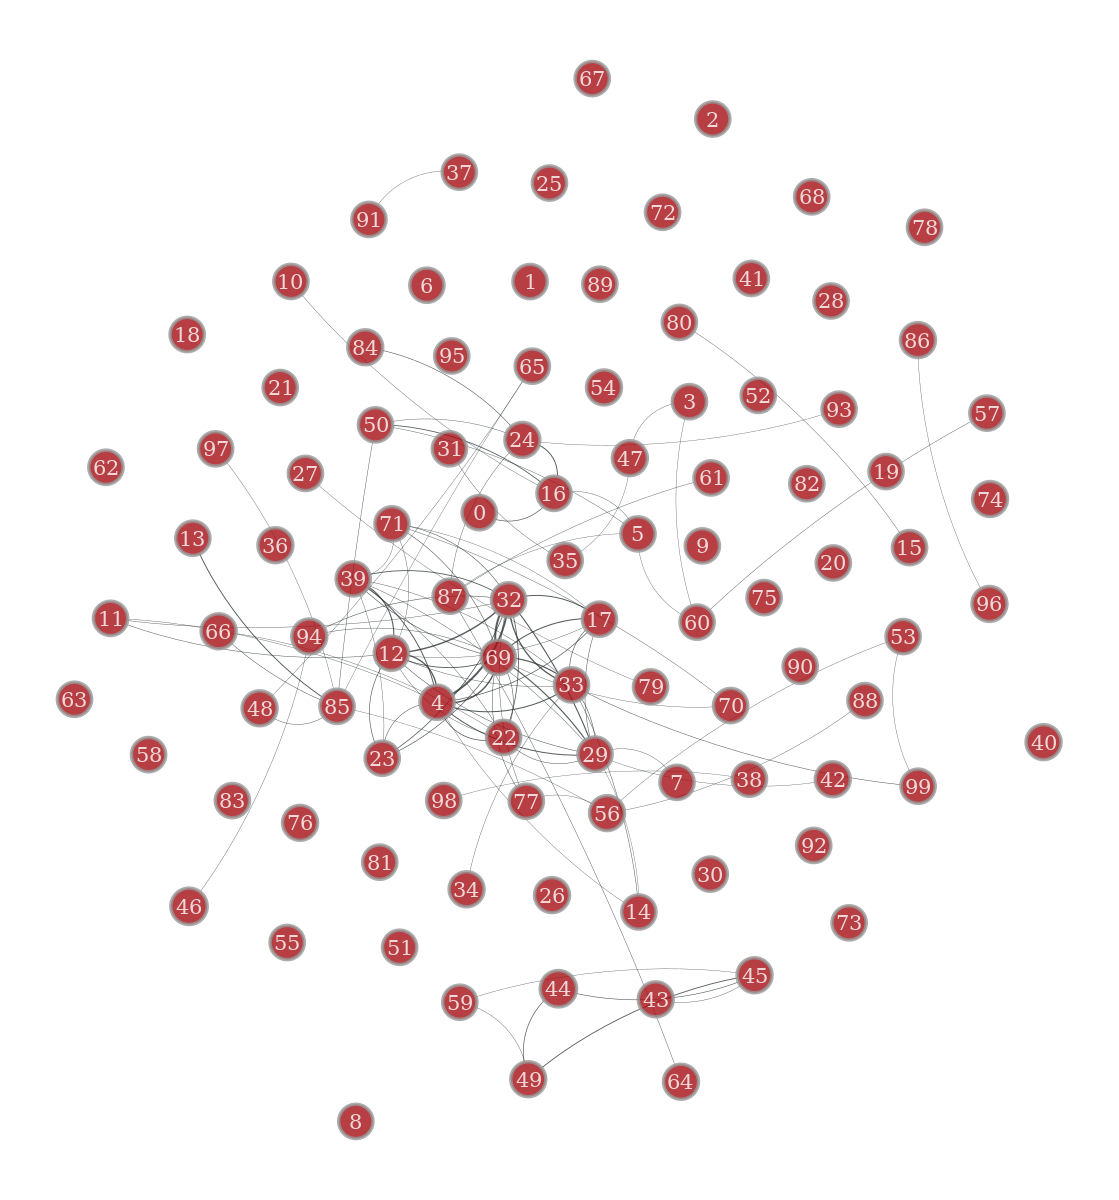

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f158326a2e0, at 0x7f1578003460>

In [236]:
graph_draw(g, vertex_text=g.vertex_index, edge_pen_width=q)

In [241]:
N = g.num_vertices()
E = g.num_edges()
[N, E, ((N * (N - 1))/2 - E)]

[100, 3769, 1181.0]

In [242]:
# We inititialize UncertainBlockState, assuming that each non-edge
# has an uncertainty of q_default, chosen to preserve the expected
# density of the original network:

q_default = (E - q.a.sum()) / ((N * (N - 1))/2 - E)

state = UncertainBlockState(g, q=q, q_default=q_default)
mcmc_equilibrate(state, wait=100, mcmc_args=dict(niter=10))

(nan, 383611, 69013)

In [243]:
u = None              # marginal posterior edge probabilities
bs = []               # partitions
cs = []               # average local clustering coefficient

def collect_marginals(s):
   global bs, u, cs
   u = s.collect_marginal(u)
   bstate = s.get_block_state()
   bs.append(bstate.levels[0].b.a.copy())
   cs.append(local_clustering(s.get_graph()).fa.mean())

mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                 callback=collect_marginals)

eprob = u.ep.eprob

PropertyArray([4.86048605e-02, 9.23092309e-02, 1.00000000e+00, ...,
               1.20012001e-03, 6.00060006e-04, 1.00010001e-04])